In [1]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import os, sys
exec(open("init_notebook.py").read())
from DataTools import DataTools
from Extractor import Extractor
from DataCleaner import DataCleaner
from RepoTools import RepoTools

current working dir/Volumes/Zarif/myStuff/research/repoPaper/src


In [2]:
%load_ext autoreload
%autoreload 2

### Load all the necessary datasets 

In [3]:
# mainDataSet
mainDatasetPath = os.path.join(os.curdir, "../data/mainData.csv")
companyDf = pd.read_csv(mainDatasetPath)

# companyToRepos
companyToRepos = Extractor.getConfig()

# DataByCIDAndYear
dataByCidYear = DataTools.loadCSVFromOutput('finalStuff/DataByCIDAndYearV2')

# matched_papers
matchedPapersInfo = DataTools.loadCSVFromOutput('finalStuff/matched_papersV2')

In [13]:
def getPath(filename):
    return os.path.join(os.curdir, '../figs/' + filename)

### Pi Chart For Number of Company with N users

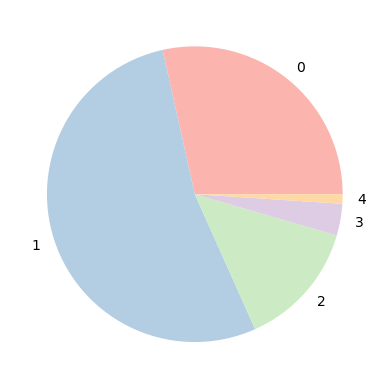

In [21]:
nUsers = []
for _ in companyToRepos:
    nUsers.append(len(_['repos']))
    
nUsersTonCompanies = {0:0, 1:0, 2:0, 3:0, 4:0}
for nUser in nUsers:
    nUsersTonCompanies[nUser] += 1
  
labels = ['0', '1', '2', '3', '4']
data = nUsersTonCompanies.values()
palette_color = sns.color_palette('Pastel1')
plt.pie(data, labels=labels, colors=palette_color)
# plt.show()
plt.savefig(getPath('pichart.png'), dpi=300, bbox_inches='tight', transparent=True)